In [8]:
%load_ext autoreload
%autoreload 2

from typing import Literal
from itertools import combinations
from tqdm import tqdm

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import ListedColormap
from pgmpy.models.MarkovNetwork import MarkovNetwork
from pgmpy.models import DiscreteBayesianNetwork

from tabicl.prior.prior_config import DEFAULT_FIXED_HP, DEFAULT_SAMPLED_HP
from tabicl.prior.dataset import PriorDataset

from gtdl.graph.scm import get_graph
from gtdl.viz.graph import draw_scms
from gtdl.graph.moral_marg import old_check
from gtdl.utils.adj import remove_axis
from gtdl.viz.imshow import imshow

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate

In [2]:
scm_fixed_hp = {
    **DEFAULT_FIXED_HP,
    'is_causal': True,
    'in_clique': False,
    # 'block_wise_dropout': False,
    # 'mlp_dropout_prob': 0.5,
    # 'num_layers': 4,
    'hidden_dim': 3,
    # 'num_causes': 2,
    'permute_features': False,
}
scm_sampled_hp = {k: v for k, v in DEFAULT_SAMPLED_HP.items() if k not in scm_fixed_hp}

min_features, max_features = 10, 10

dataset = PriorDataset(
    batch_size = 48,
    min_features = min_features,
    max_features = max_features,
#     max_classes = 3,
    batch_size_per_gp = 3, # low value slows dows, but for visualization it's ok
    scm_fixed_hp=scm_fixed_hp,
    scm_sampled_hp=scm_sampled_hp,
)

xs, ys, ds, seq_lens, train_sizes, adjs, priors = dataset.prior.get_batch()
print(f'{len(priors) = }')

len(priors) = 48


In [3]:
(
    graphs_full, 
    graphs_moma, 
    graphs_lean_moma,
    nodelists,
) = map(list, zip(*[(
    prior.graph_full, 
    prior.graph_moma, 
    prior.graph_lean_moma,
    prior.graph_full.graph['nodes_include'],
) for prior in priors]))

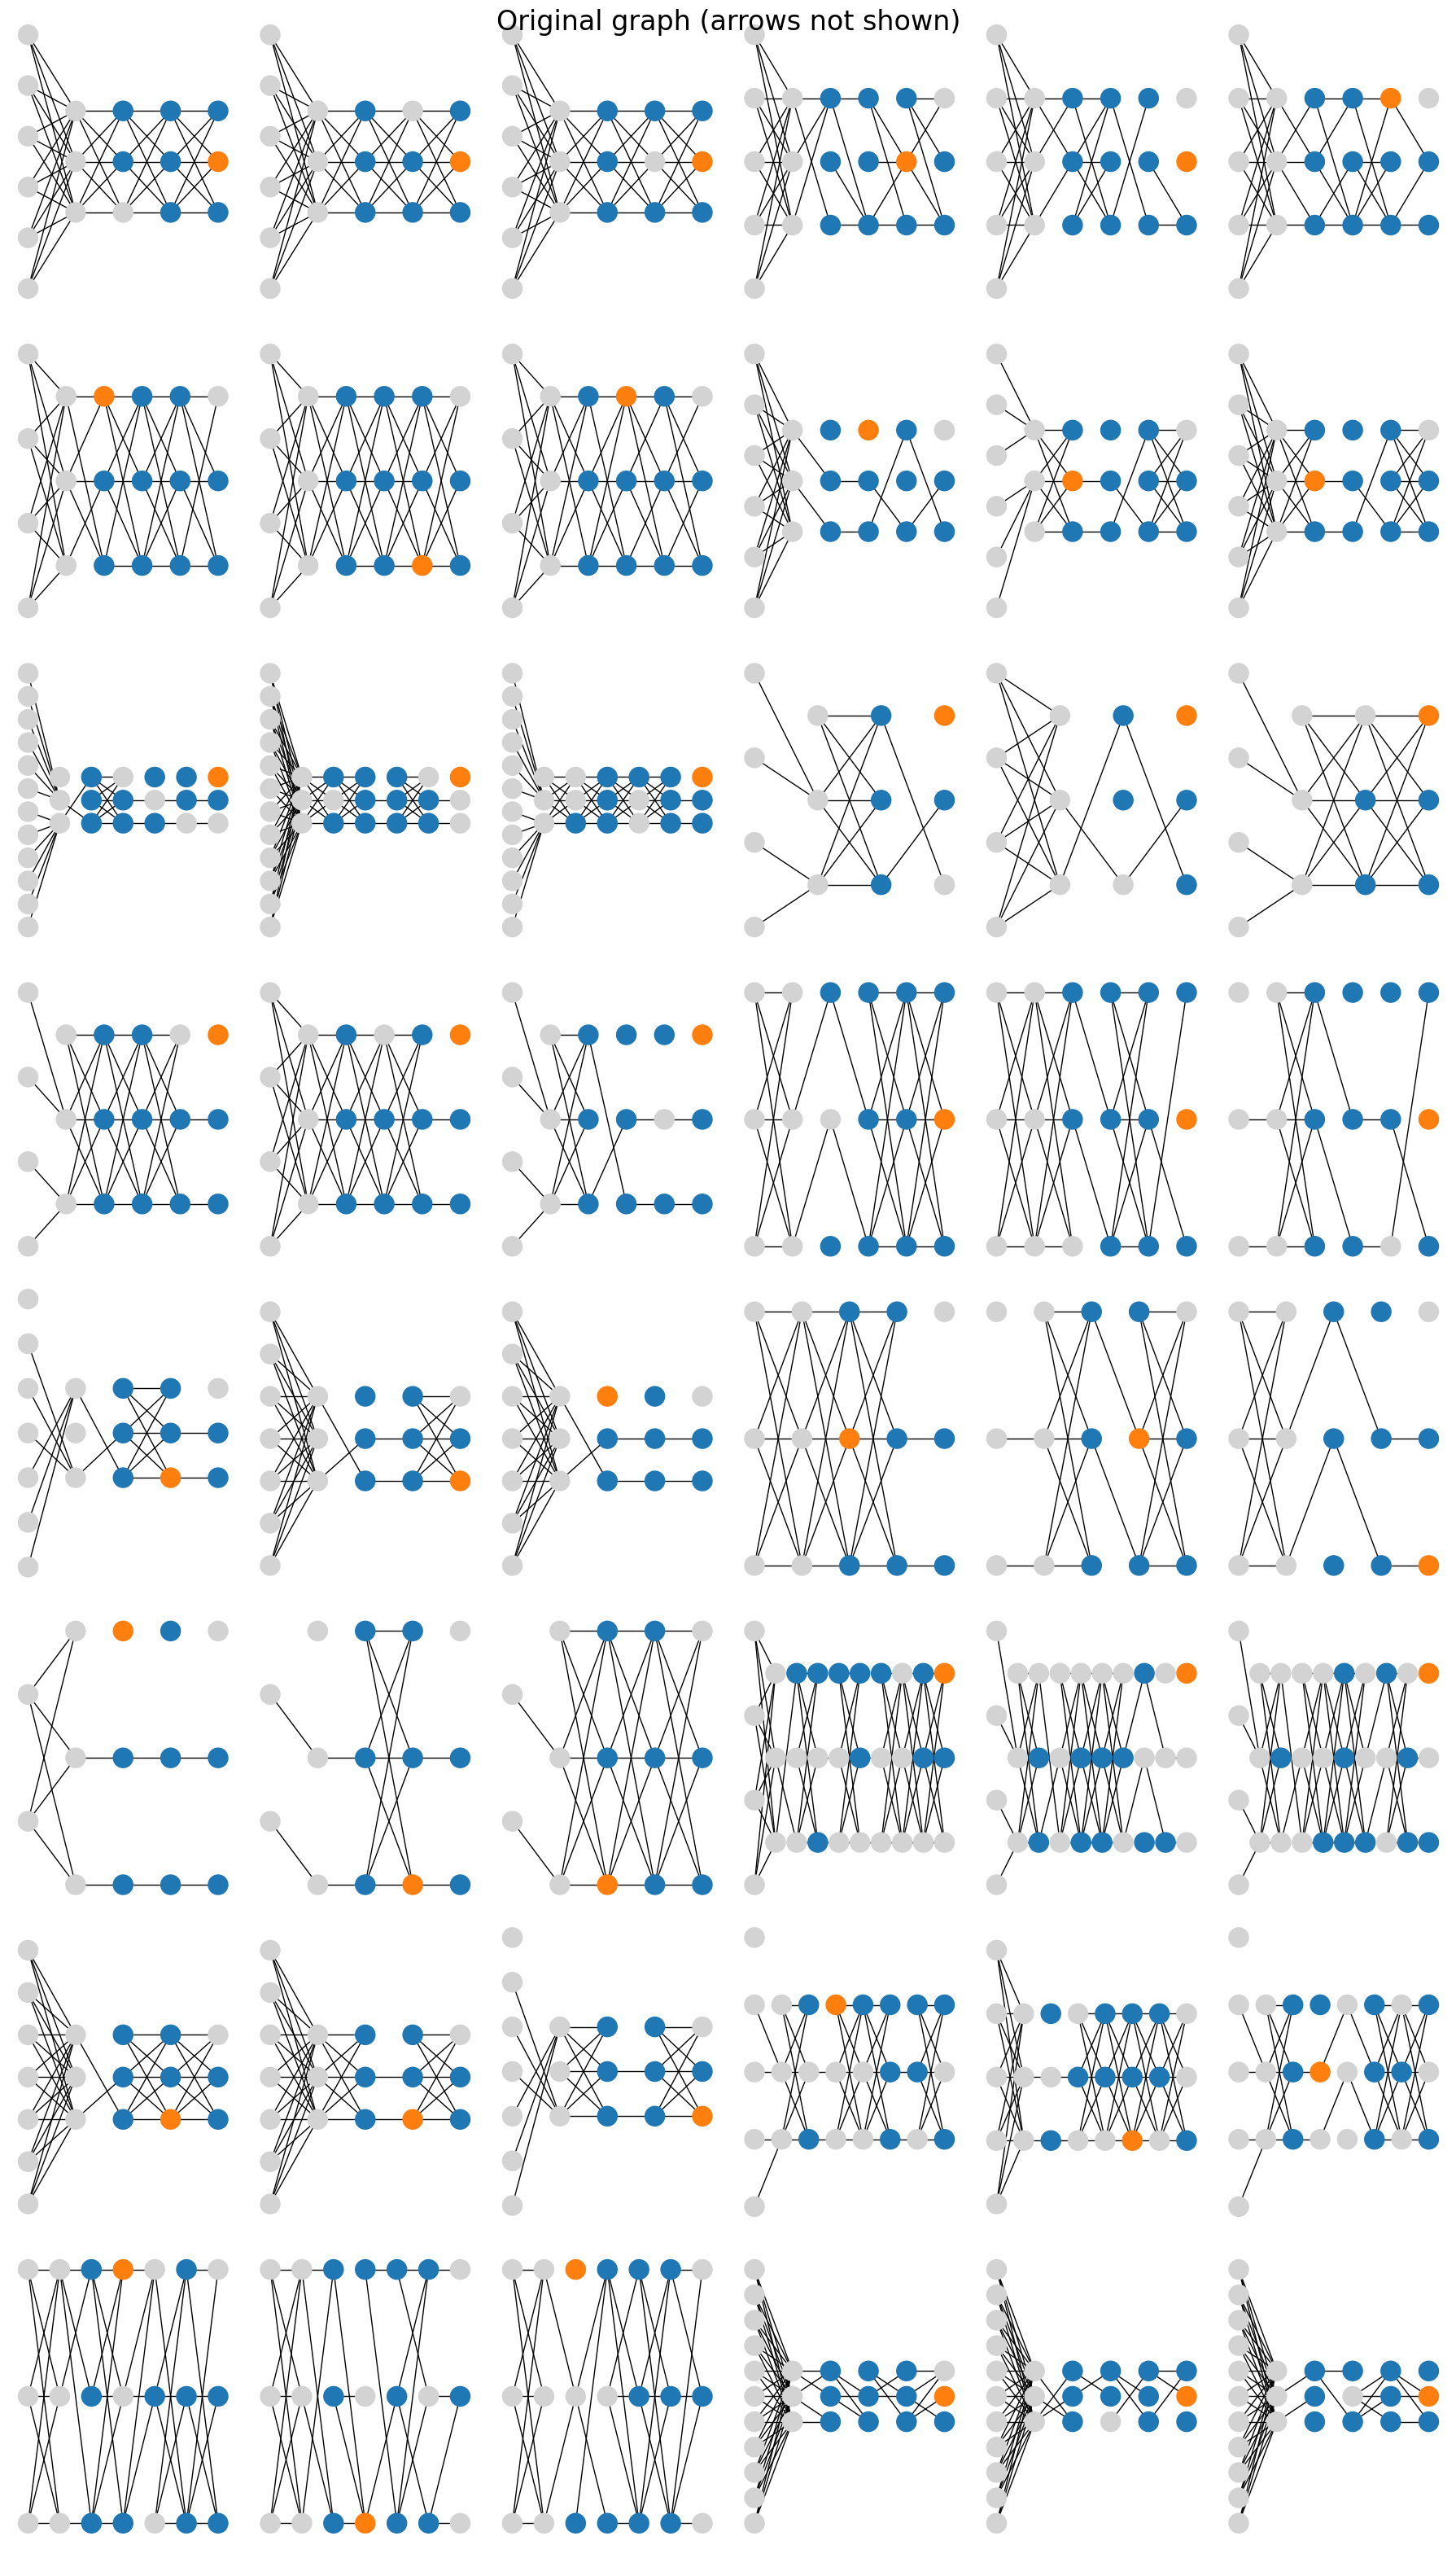

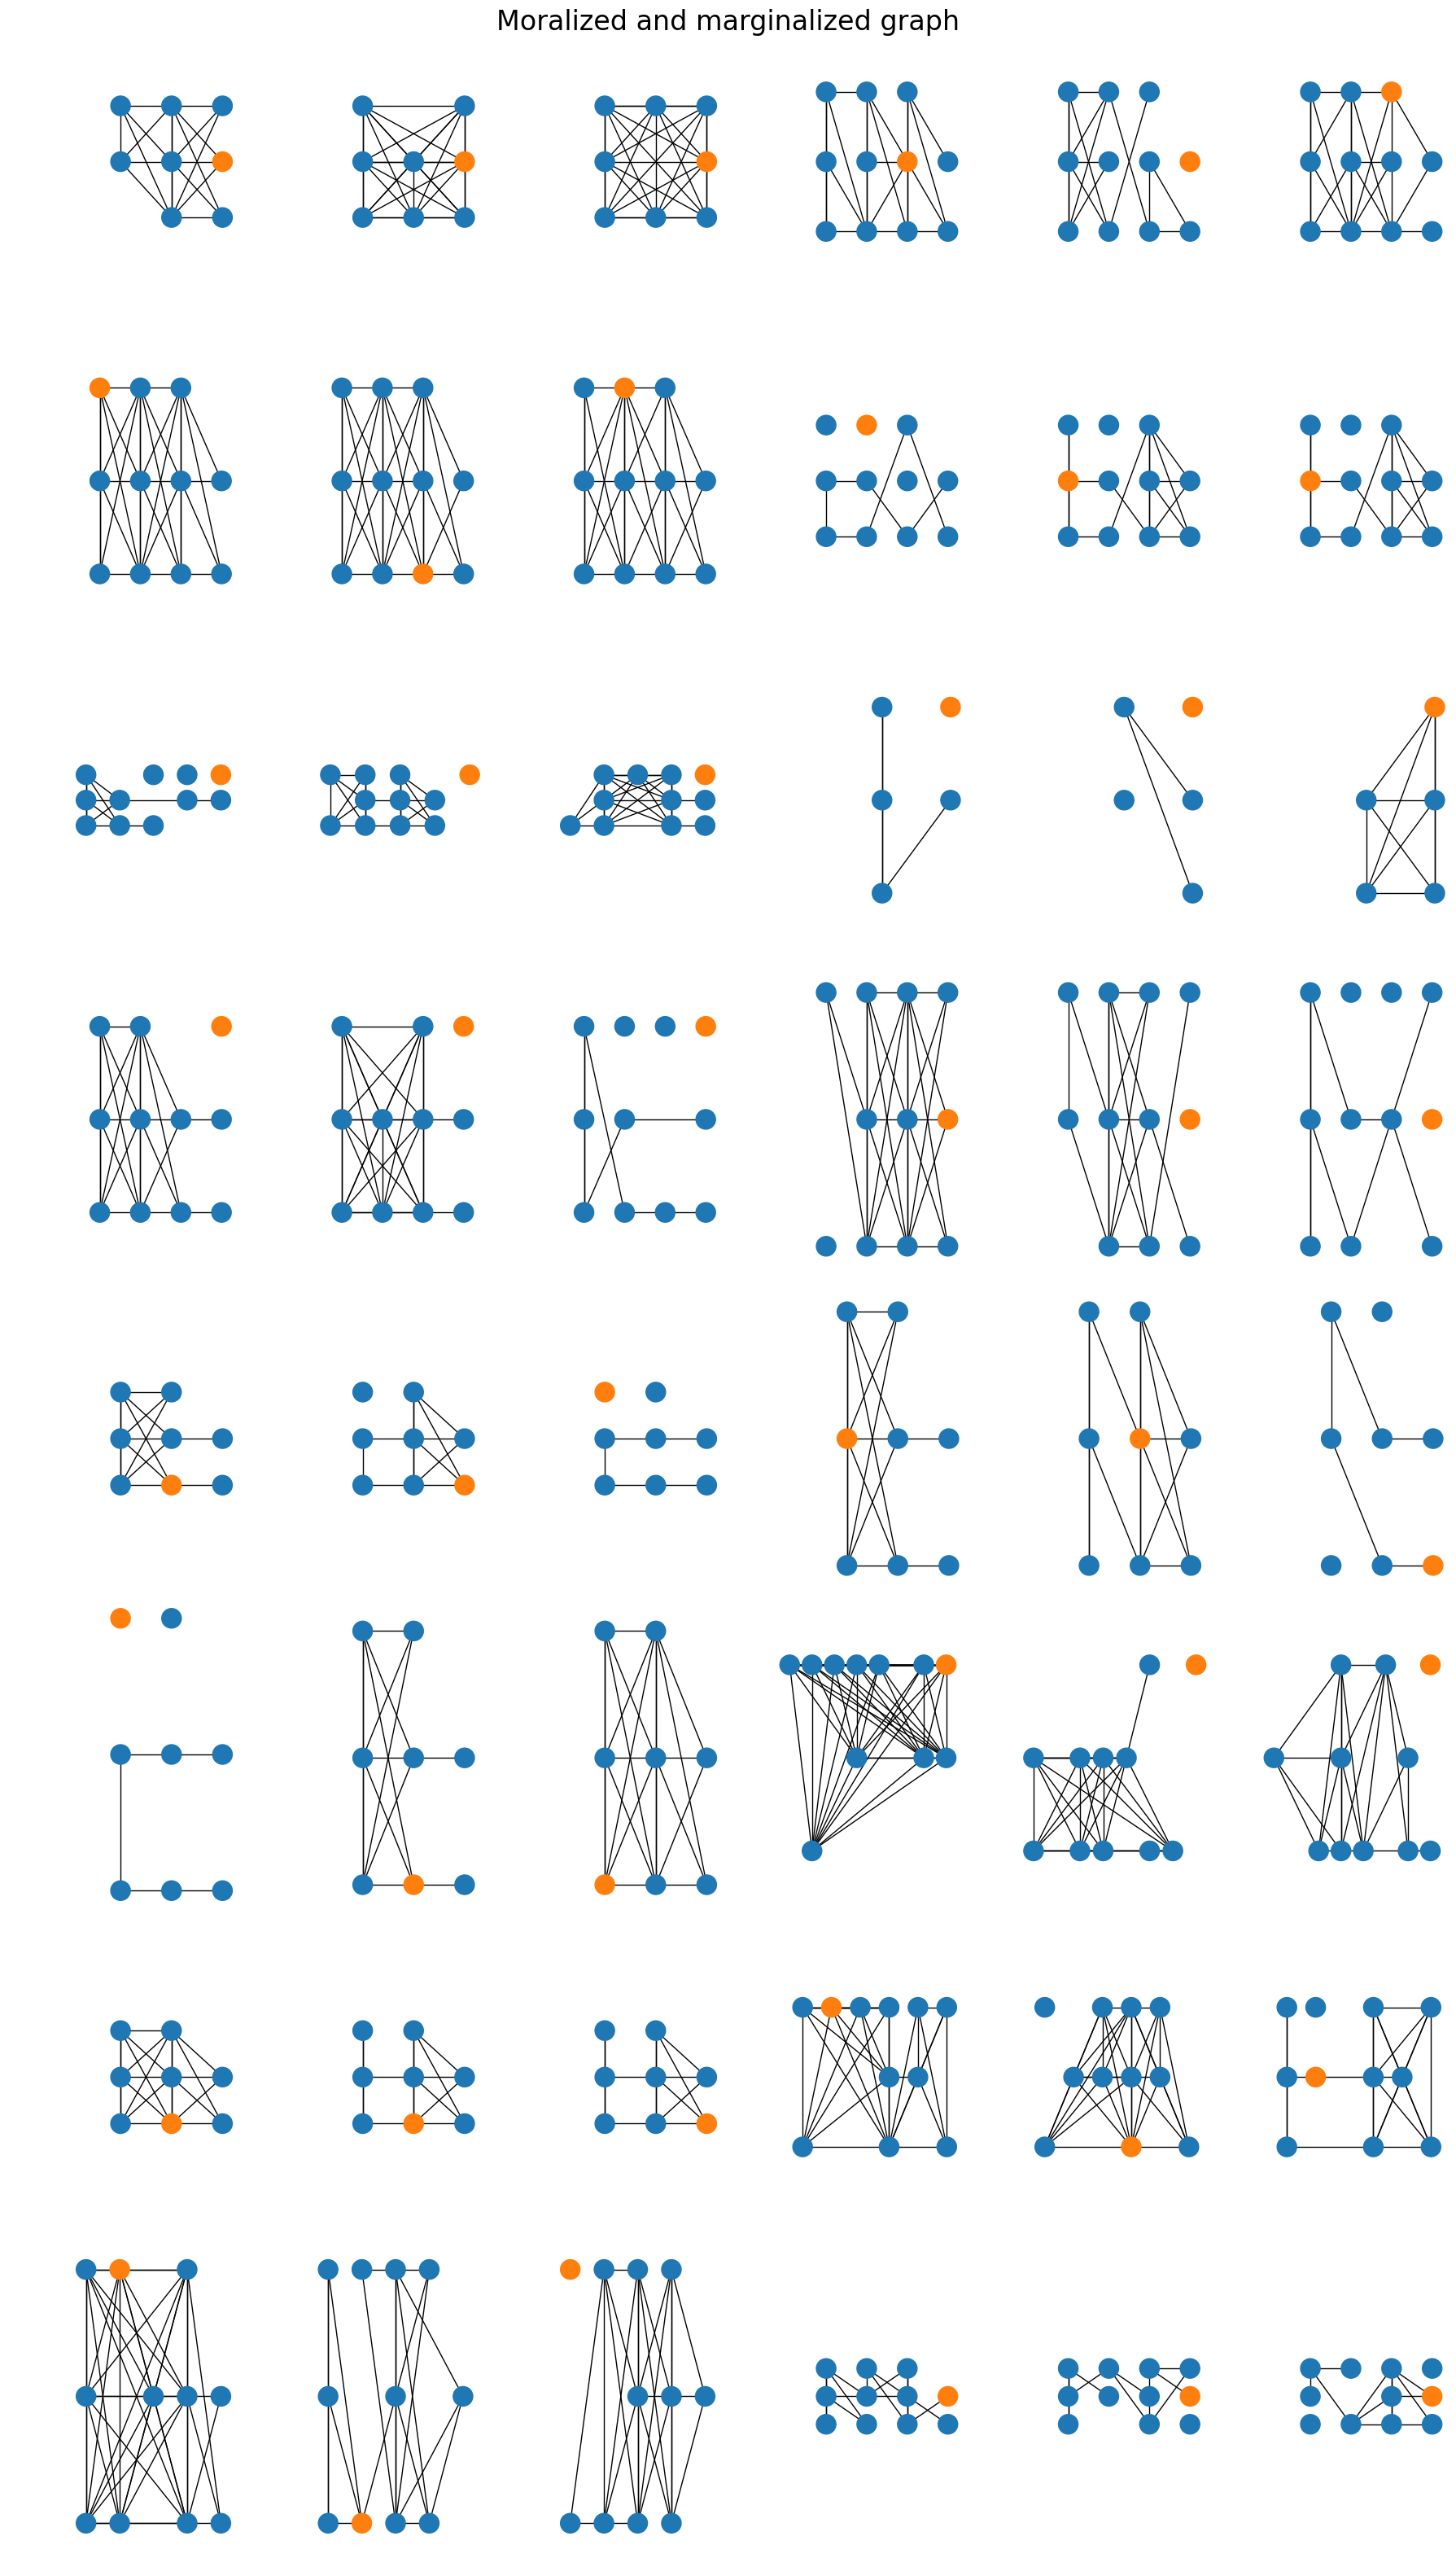

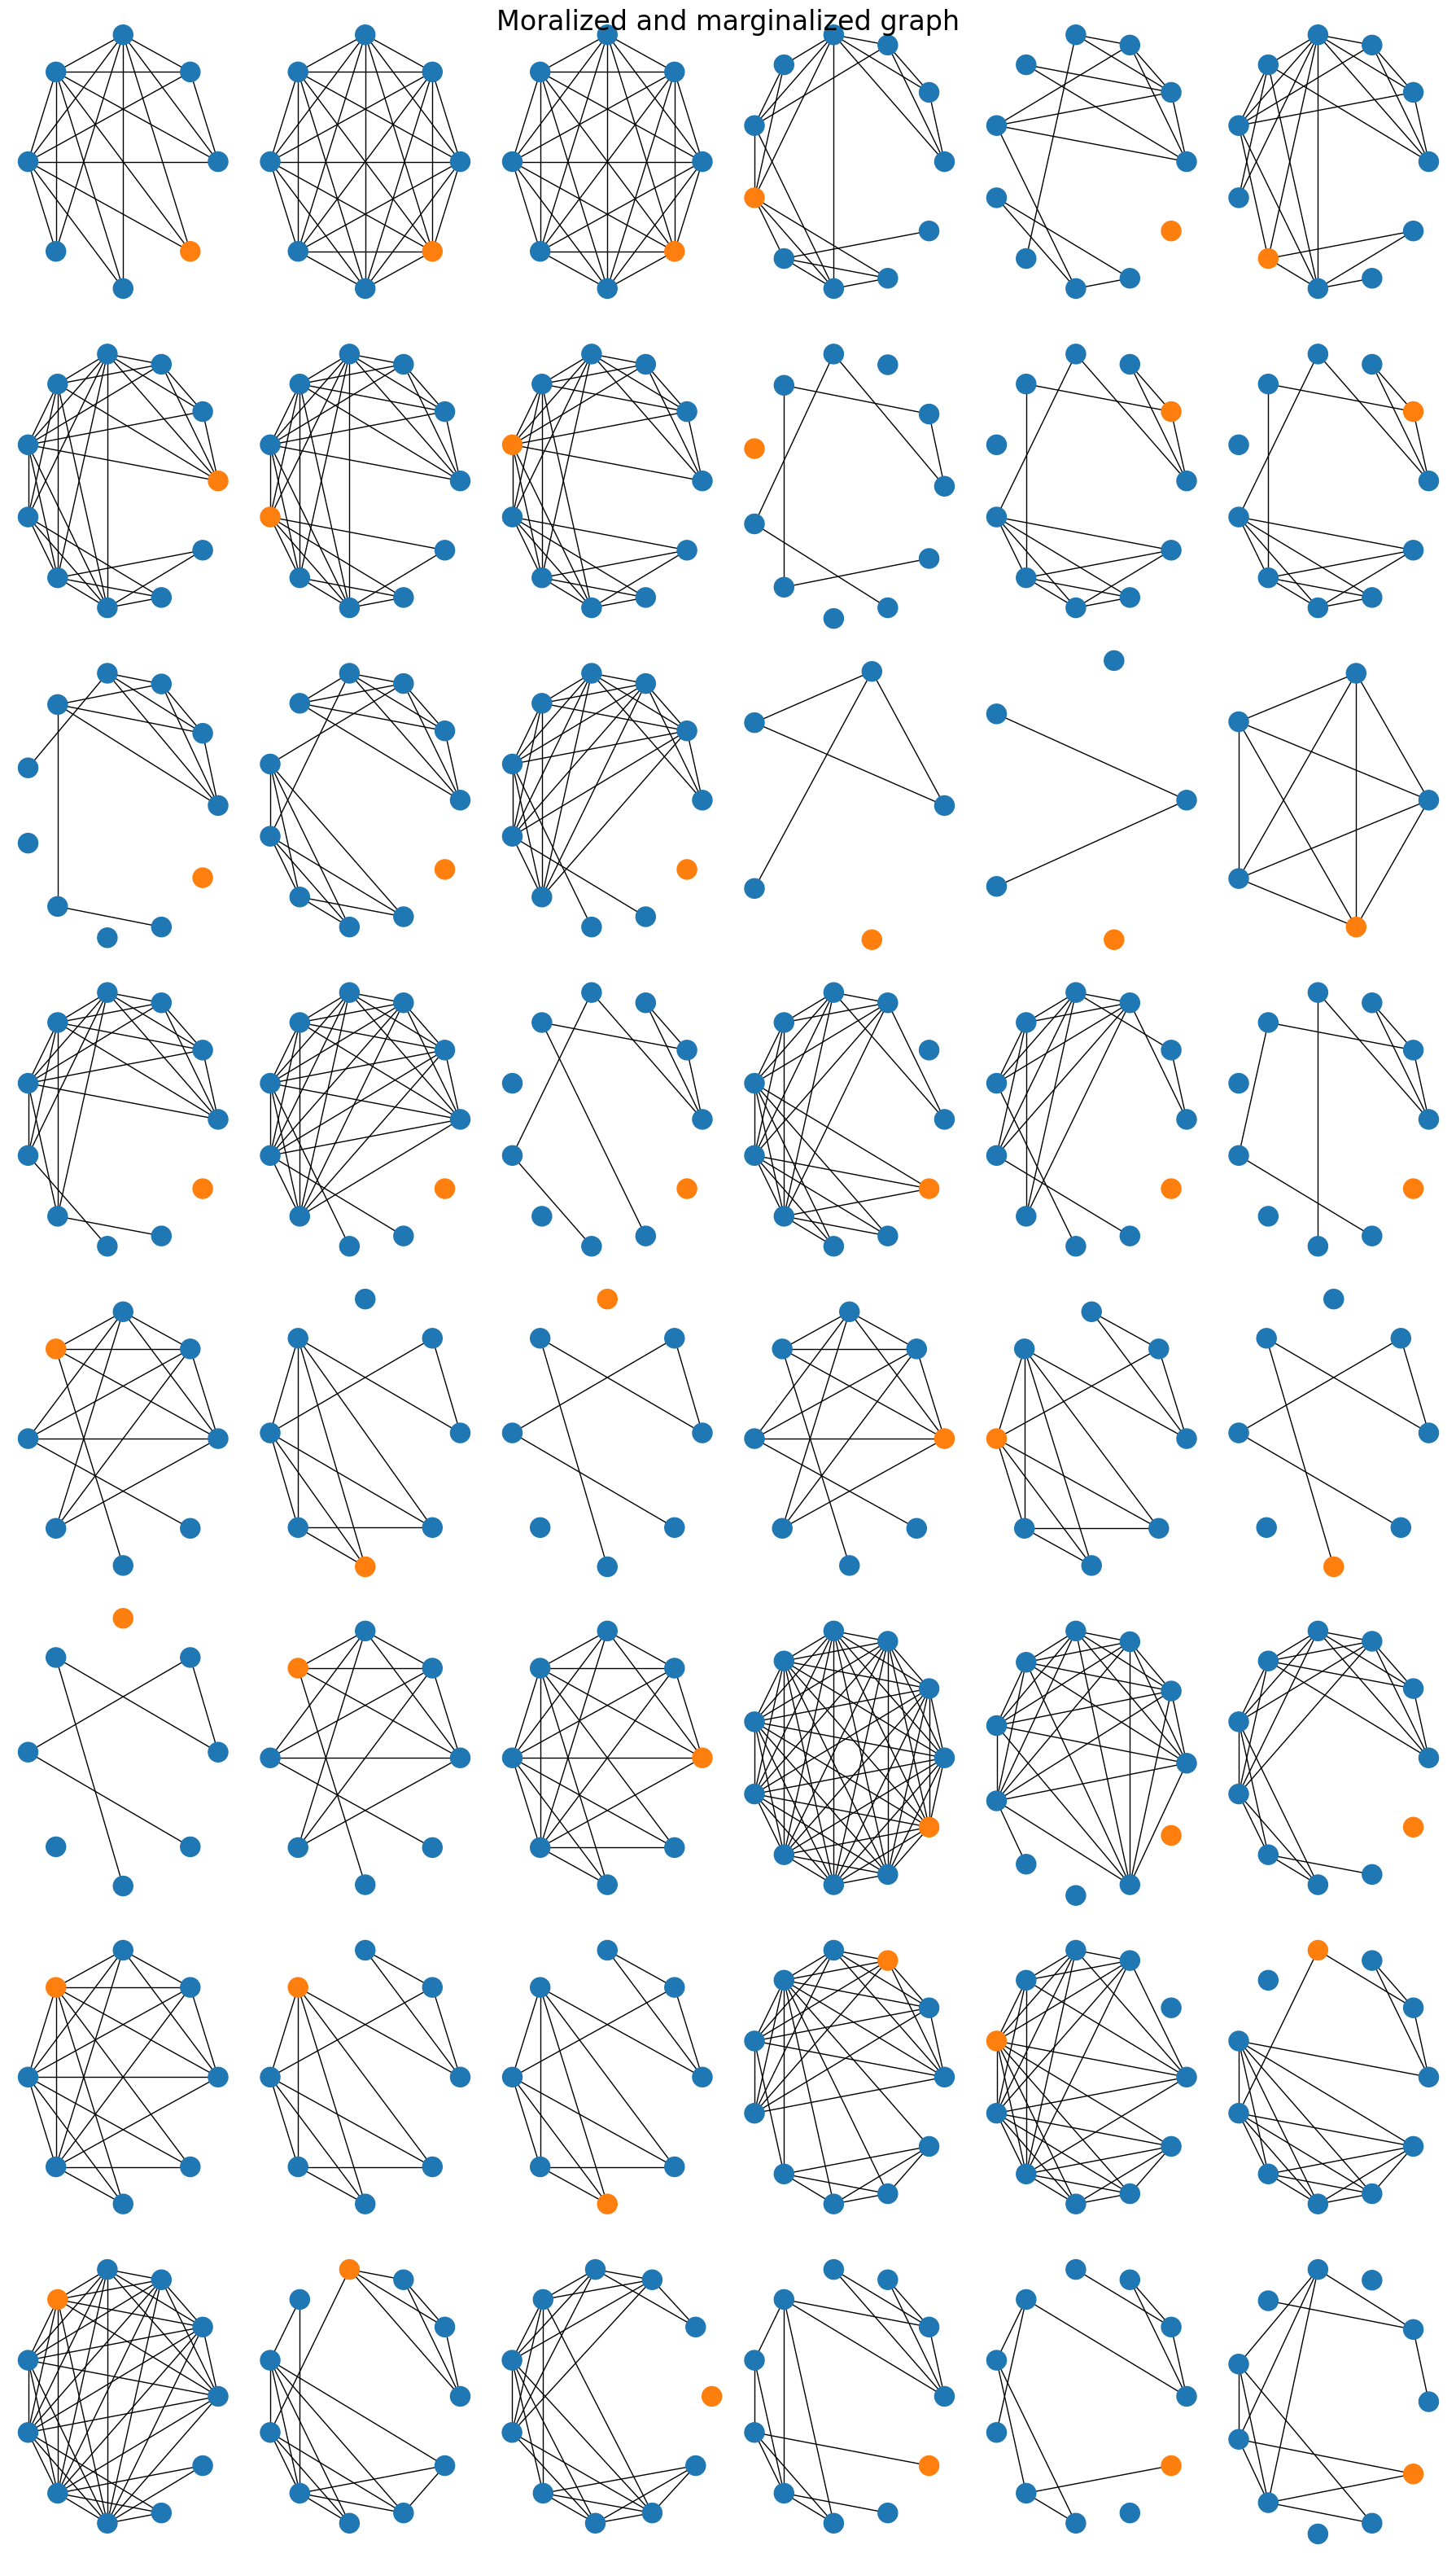

In [4]:
n_graphs = len(graphs_full)
n_cols = 6
cmap = ListedColormap(['white', 'black'])

draw_scms_param = dict(
    n_rows = np.ceil(n_graphs / n_cols).astype(int),
    figsize = (3, 4),
)

draw_scms(
    graphs_full, 
    suptitle='Original graph (arrows not shown)',
    **draw_scms_param
)


draw_scms(
    graphs_moma, 
    suptitle='Moralized and marginalized graph',
    nodelists= nodelists,
    edge_alpha = 1.,
    **draw_scms_param
)

draw_scms(
    graphs_lean_moma, 
    suptitle='Moralized and marginalized graph',
    nodelists = nodelists,
    pos = 'circular',
    edge_alpha = 1.,
    **draw_scms_param
)



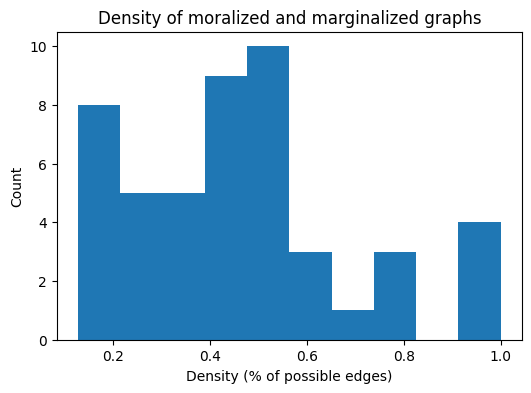

In [7]:
densities = [nx.density(g) for g in graphs_lean_moma]

fig, ax = plt.subplots(figsize=(6,4))
ax.hist(densities, bins=10)
ax.set(
    title='Density of moralized and marginalized graphs',
    xlabel=r'Density (% of possible edges)',
    ylabel='Count',
)
plt.show()

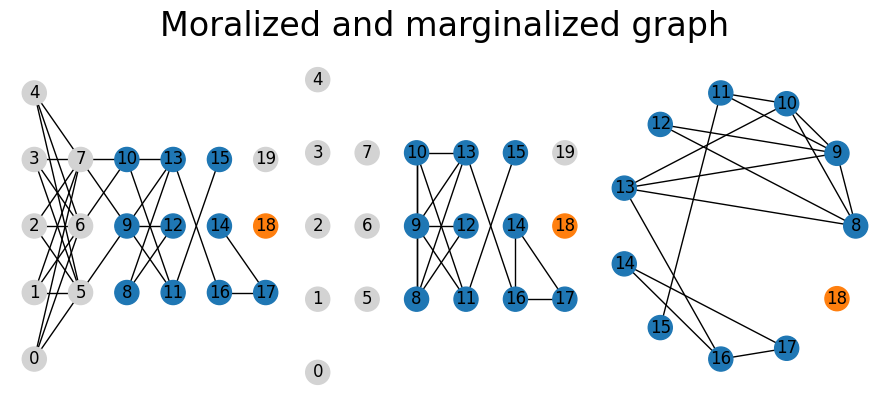

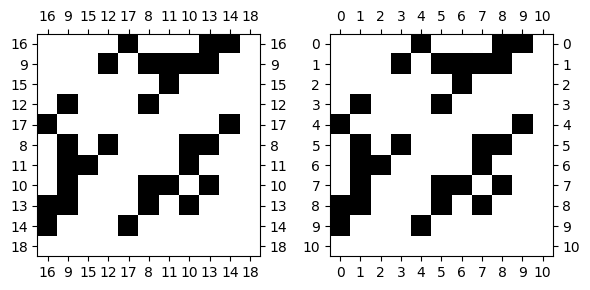

In [9]:
graph_idx = -1
graph_idx = np.random.randint(0, n_graphs - 1)

# while True:
#     graph_idx = np.random.randint(0, n_graphs - 1)
#     d = ds[graph_idx].item()
#     if d == 10:
#         break

d = ds[graph_idx].item()
prior = priors[graph_idx]

graph_full = graphs_full[graph_idx]
graph_moma = graphs_moma[graph_idx]
graph_lean = graphs_lean_moma[graph_idx]
nodelist = nodelists[graph_idx]

adj = adjs[graph_idx].clone()

draw_scms(
    [graph_full, graph_moma, graph_lean],
    suptitle='Moralized and marginalized graph',
    nodelists = [None, None, nodelist],
    pos = ['layer', 'layer', 'circular'],
    edge_alpha = 1.,
    figsize=(3, 4),
    with_labels=True,
)

imshow(
    matrices = [prior.adj, adj], 
    tick_labels=[nodelist, None],
    turn_off_axis=False, 
    cmap = ListedColormap(['white', 'black']),
    figsize=(3,3)
)

assert prior.adj.sum() == adj.sum()

if d < max_features:
    adj = remove_axis(adj, list(range(d, max_features)))
assert torch.allclose(prior.adj, adj)
